# How You Can Avoid Car Accident in 2020
see post on medium.com:
https://medium.com/@RonghuiZhou/how-you-can-avoid-car-accident-in-2020-c9626c9b6f68


### Use LR/KNN/Decision Tree/Random Forest classification algorithms from sklearn to predict the accident severity

Due to the limit of computer capacity, I am focusing on Montgomery County in the State of Pennsylvania. I will only select a few features I believe are more relavant to severity. Categorical data will be treated with Pandas get_dummies method. Rows with missing values will be dropped.

### Data source
https://www.kaggle.com/sobhanmoosavi/us-accidents


### Acknowledgements

Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, 2019.

Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. "Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights." In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.


####  Author
Ronghui Zhou, zhou.uf@gmail.com
https://github.com/RonghuiZhou

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

### Step 1. Import libraries

In [2]:
# Import numpy, pandas, matpltlib.pyplot, sklearn modules and seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

# Import dependencies
import os
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
# from config import username, password
import time
from pathlib import Path
import pickle
from collections import Counter
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.ensemble.forest import RandomForestClassifier
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Activation, Dense
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.datasets import make_blobs
import seaborn as sns


from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc

from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import GridSearchCV

from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

D:\AnacondaJupyter\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


### Step 2. Import the dataset

In [3]:
# Import the data
df = pd.read_csv('../resources/Cleaned_Accidents_Data_v4_CA_ONLY.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794937 entries, 0 to 794936
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    794937 non-null  object 
 1   Severity              794937 non-null  int64  
 2   Latitude              794937 non-null  float64
 3   Longitude             794937 non-null  float64
 4   City                  794937 non-null  object 
 5   County                794937 non-null  object 
 6   Zipcode               794937 non-null  int64  
 7   Temperature_F         794937 non-null  float64
 8   Visibility_miles      794937 non-null  float64
 9   Wind_Speed_mph        794937 non-null  float64
 10  Precipitation_inches  794937 non-null  float64
 11  Weather_Condition     794937 non-null  object 
 12  Speed_Bump            794937 non-null  bool   
 13  Cross_Walk            794937 non-null  bool   
 14  Yield_Sign            794937 non-null  bool   
 15  

### Step 3. Extract year, month, day, hour, weekday, and time to clear accidents

In [4]:
# Convert Start_Time and End_Time to datetypes
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Extract year, month, day, hour and weekday
df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.strftime('%b')
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
td='Time_Duration(min)'
df[td]=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))
df.info()

KeyError: 'Start_Time'

### Step 4. Deal with outliers

#### A. Drop rows with negative time_duration

In [5]:
# Check if there is any negative time_duration values
df[td][df[td]<=0]

NameError: name 'td' is not defined

In [6]:
# # Drop the rows with td<0

# neg_outliers=df[td]<=0

# # Set outliers to NAN
# df[neg_outliers] = np.nan

# Drop rows with negative td
df.dropna(subset=[td],axis=0,inplace=True)
df.info()

NameError: name 'td' is not defined

In [7]:
# Double check to make sure no more negative td
df[td][df[td]<=0]

NameError: name 'td' is not defined

### Step 4. Deal with outliers

#### B. Fill outliers with median values

In [8]:
# Remove outliers for Time_Duration(min): n * standard_deviation (n=3), backfill with median

n=3

median = df[td].median()
std = df[td].std()
outliers = (df[td] - median).abs() > std*n

# Set outliers to NAN
df[outliers] = np.nan

# Fill NAN with median
df[td].fillna(median, inplace=True)

df.info()

NameError: name 'td' is not defined

In [9]:
# Print time_duration information
print('Max time to clear an accident: {} minutes or {} hours or {} days; Min to clear an accident td: {} minutes.'.format(df[td].max(),round(df[td].max()/60), round(df[td].max()/60/24), df[td].min()))

NameError: name 'td' is not defined

In [10]:
# Export the data
# df.to_csv('./US_Accidents_May19_clean.csv',index=False)

### Step 5. Select a list of features for machine learning algorithms

 Only select relavant columns without overwhelming the computer

In [11]:
df.head()

,ID,Severity,Latitude,Longitude,City,County,Zipcode,Temperature_F,Visibility_miles,Wind_Speed_mph,Precipitation_inches,Weather_Condition,Speed_Bump,Cross_Walk,Yield_Sign,Intersection,No_Exit,Railway,Roundabout,Stop_Sign,Traffic,Traffic_Light,Turning_Loop,Year,Month,Time,Part_of_Week,Time_of_Day
0,A-729,3,38.085300,-122.233017,Vallejo,Solano,94591,75.0,10.0,5.8,0.0,Clear,False,False,False,False,False,False,False,False,False,False,False,2016,June,10,Weekday,Morning
1,A-730,3,37.631813,-122.084167,Hayward,Alameda,94544,75.0,10.0,4.6,0.0,Clear,False,False,False,False,False,False,False,False,False,False,False,2016,June,10,Weekday,Morning
2,A-731,2,37.896564,-122.070717,Walnut Creek,Contra Costa,94595,82.9,10.0,4.6,0.0,Clear,False,False,False,False,False,False,False,False,False,False,False,2016,June,10,Weekday,Morning
3,A-732,3,37.334255,-122.032471,Cupertino,Santa Clara,95014,75.9,10.0,4.6,0.0,Clear,False,False,False,False,False,False,False,False,False,False,False,2016,June,10,Weekday,Morning
4,A-733,2,37.250729,-121.910713,San Jose,Santa Clara,95118,75.2,10.0,5.8,0.0,Clear,False,False,False,False,False,False,False,False,False,False,False,2016,June,10,Weekday,Morning


In [21]:
# Set the list of features to include in Machine Learning 
# 'Severity', 
# 'Start_Time', 
# 'City', 
# 'County', 
# 'State', 
# 'Zipcode', 
# 'Temperature(F)
# 'Visibility(mi)', 
# 'Precipitation(in)', 
# 'Amenity', 
# 'Bump', 
# 'Crossing', 
# 'Give_Way', 
# 'Junction', 
# 'No_Exit', 
# 'Railway', 
# 'Roundabout', 
# 'Station', 
# 'Stop', 
# 'Traffic_Calming', 
# 'Traffic_Signal', 
# 'Turning_Loop', 
# 'Month', 
# 'Hour', 
# 'Weekday' 
# ID



feature_lst=['Severity' ,'County' ,'Temperature_F' ,'Visibility_miles' ,'Precipitation_inches' ,'Speed_Bump' ,'Cross_Walk' ,'Yield_Sign' ,'Intersection' ,'No_Exit' ,'Railway' ,'Roundabout' ,'Stop_Sign' ,'Traffic' ,'Traffic_Light' ,'Turning_Loop' ,'Month' ,'Time' ,'Part_of_Week' ]

In [23]:
# Select the dataset to include only the selected features
df_sel=df.copy()

df_sel=df_sel[feature_lst].copy()
df_sel.dtypes

Severity                  int64
County                   object
Temperature_F           float64
Visibility_miles        float64
Precipitation_inches    float64
Speed_Bump                 bool
Cross_Walk                 bool
Yield_Sign                 bool
Intersection               bool
No_Exit                    bool
Railway                    bool
Roundabout                 bool
Stop_Sign                  bool
Traffic                    bool
Traffic_Light              bool
Turning_Loop               bool
Month                    object
Time                      int64
Part_of_Week             object
dtype: object

In [24]:
# Export the data with selected features
# df_sel.to_csv('./US_Accidents_Features_Selected.csv',index=False)

### Step 6. Drop rows with missing values

In [25]:
# Check missing values
df_sel.isnull().mean()

Severity                0.0
County                  0.0
Temperature_F           0.0
Visibility_miles        0.0
Precipitation_inches    0.0
Speed_Bump              0.0
Cross_Walk              0.0
Yield_Sign              0.0
Intersection            0.0
No_Exit                 0.0
Railway                 0.0
Roundabout              0.0
Stop_Sign               0.0
Traffic                 0.0
Traffic_Light           0.0
Turning_Loop            0.0
Month                   0.0
Time                    0.0
Part_of_Week            0.0
dtype: float64

In [26]:
df_sel.dropna(subset=df_sel.columns[df_sel.isnull().mean()!=0], how='any', axis=0, inplace=True)
df_sel.shape

(794937, 19)

In [27]:
# Export the data with selected features
# df_sel.to_csv('./US_Accidents_Features_Selected.csv',index=False)

### Step 7. Select the state of interest: CA; and County of interest: Los Angeles
   

Due to the limitation of personal laptop, the whole US dataset is too big to handle

In [28]:
# Import data if it was already exported based on previous work
# df_sel=pd.read_csv('./US_Accidents_May19_clean_sel_dropna.csv')

trydf = df_sel.copy()
trydf



,Severity,County,Temperature_F,Visibility_miles,Precipitation_inches,Speed_Bump,Cross_Walk,Yield_Sign,Intersection,No_Exit,Railway,Roundabout,Stop_Sign,Traffic,Traffic_Light,Turning_Loop,Month,Time,Part_of_Week
0,3,Solano,75.0,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,June,10,Weekday
1,3,Alameda,75.0,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,June,10,Weekday
2,2,Contra Costa,82.9,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,June,10,Weekday
3,3,Santa Clara,75.9,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,June,10,Weekday
4,2,Santa Clara,75.2,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,June,10,Weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794932,2,Riverside,86.0,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,August,18,Weekday
794933,2,San Diego,70.0,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,August,19,Weekday
794934,2,Orange,73.0,10.0,0.0,False,False,False,True,False,False,False,False,False,False,False,August,19,Weekday
794935,2,Los Angeles,71.0,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,August,19,Weekday


In [29]:
# # Set state
# state='CA'

# # select the state of California
# df_state=trydf.loc[trydf.State==state].copy()
# df_state.drop('State',axis=1, inplace=True)
# df_state.info()

In [30]:
# Map of accidents, color code by county

# sns.scatterplot(x='Start_Lng', y='Start_Lat', data=trydf, hue='State', legend=False, s=20)
# plt.show()

In [31]:
# Set county
# county='Los Angeles'

# # Select the county of LA 
# df_county=df_state.loc[df_state.County==county].copy()
# df_county.drop('County',axis=1, inplace=True)
# df_county.info()

#selecting zipcode 90022 for testing purposes
# zc='90022'

# # Select the county of LA 
# df_county=df_state.loc[df_state.Zipcode==zc].copy()
# df_county.drop('Zipcode',axis=1, inplace=True)
# df_county.info()

In [32]:
# Map of accidents, color code by city

# sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_county, hue='City', legend=False, s=20)
# plt.show()

In [33]:
# df_state.to_csv('./Accident_California_Only_Features_Selected.csv',index=False)

### Step 8. Deal with categorical data: pd.get_dummies()


# Generate dummies for categorical data
df_county_dummy = pd.get_dummies(df_county,drop_first=True)

# Export data
# df_county_dummy.to_csv('./US_Accidents_May19_{}_dummy.csv'.format(state),index=False)

df_county_dummy.info()

### Step 9. Predict the accident severity with various supervised machine learning algorithms

#### Data preparation: train_test_split

In [34]:
# trydf2 = pd.read_csv('Accident_California_Only_Features_Selected.csv')

trydf2 = trydf.copy()

trydf2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 794937 entries, 0 to 794936
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Severity              794937 non-null  int64  
 1   County                794937 non-null  object 
 2   Temperature_F         794937 non-null  float64
 3   Visibility_miles      794937 non-null  float64
 4   Precipitation_inches  794937 non-null  float64
 5   Speed_Bump            794937 non-null  bool   
 6   Cross_Walk            794937 non-null  bool   
 7   Yield_Sign            794937 non-null  bool   
 8   Intersection          794937 non-null  bool   
 9   No_Exit               794937 non-null  bool   
 10  Railway               794937 non-null  bool   
 11  Roundabout            794937 non-null  bool   
 12  Stop_Sign             794937 non-null  bool   
 13  Traffic               794937 non-null  bool   
 14  Traffic_Light         794937 non-null  bool   
 15  

In [35]:
trydf2.dtypes

Severity                  int64
County                   object
Temperature_F           float64
Visibility_miles        float64
Precipitation_inches    float64
Speed_Bump                 bool
Cross_Walk                 bool
Yield_Sign                 bool
Intersection               bool
No_Exit                    bool
Railway                    bool
Roundabout                 bool
Stop_Sign                  bool
Traffic                    bool
Traffic_Light              bool
Turning_Loop               bool
Month                    object
Time                      int64
Part_of_Week             object
dtype: object

In [36]:
trydf2['Severity'] = pd.to_numeric(trydf2['Severity'], downcast='integer')

In [37]:
checktypesdf = trydf2.copy()

In [39]:
checktypesdf['Time'] = pd.to_numeric(checktypesdf['Time'], downcast='float')

In [40]:
checktypesdf.dtypes

Severity                   int8
County                   object
Temperature_F           float64
Visibility_miles        float64
Precipitation_inches    float64
Speed_Bump                 bool
Cross_Walk                 bool
Yield_Sign                 bool
Intersection               bool
No_Exit                    bool
Railway                    bool
Roundabout                 bool
Stop_Sign                  bool
Traffic                    bool
Traffic_Light              bool
Turning_Loop               bool
Month                    object
Time                    float32
Part_of_Week             object
dtype: object

In [41]:
checktypesdf.head()

,Severity,County,Temperature_F,Visibility_miles,Precipitation_inches,Speed_Bump,Cross_Walk,Yield_Sign,Intersection,No_Exit,Railway,Roundabout,Stop_Sign,Traffic,Traffic_Light,Turning_Loop,Month,Time,Part_of_Week
0,3,Solano,75.0,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,June,10.0,Weekday
1,3,Alameda,75.0,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,June,10.0,Weekday
2,2,Contra Costa,82.9,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,June,10.0,Weekday
3,3,Santa Clara,75.9,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,June,10.0,Weekday
4,2,Santa Clara,75.2,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,June,10.0,Weekday


In [42]:
feature_lst=[ 'County', 'Temperature(F)', 'Visibility(mi)', 'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Month', 'Hour', 'Weekday' ]

dummifydf=checktypesdf[feature_lst].copy()
dummifydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326982 entries, 0 to 326981
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   City               326982 non-null  object 
 1   County             326982 non-null  object 
 2   Zipcode            326982 non-null  object 
 3   Temperature(F)     326982 non-null  float32
 4   Visibility(mi)     326982 non-null  float32
 5   Precipitation(in)  326982 non-null  float32
 6   Amenity            326982 non-null  bool   
 7   Bump               326982 non-null  bool   
 8   Crossing           326982 non-null  bool   
 9   Give_Way           326982 non-null  bool   
 10  Junction           326982 non-null  bool   
 11  No_Exit            326982 non-null  bool   
 12  Railway            326982 non-null  bool   
 13  Roundabout         326982 non-null  bool   
 14  Station            326982 non-null  bool   
 15  Stop               326982 non-null  bool   
 16  Tr

In [43]:
dummifydf=checktypesdf.copy()
dummifydf.dtypes

Severity                   int8
County                   object
Temperature_F           float64
Visibility_miles        float64
Precipitation_inches    float64
Speed_Bump                 bool
Cross_Walk                 bool
Yield_Sign                 bool
Intersection               bool
No_Exit                    bool
Railway                    bool
Roundabout                 bool
Stop_Sign                  bool
Traffic                    bool
Traffic_Light              bool
Turning_Loop               bool
Month                    object
Time                    float32
Part_of_Week             object
dtype: object

In [44]:
dummifydf['Zipcode'] = dummifydf['Zipcode'].str[:5]

KeyError: 'Zipcode'

In [45]:
dummifydf.rename(columns = {'Start_Lat':'Latitude', 'Start_Lng':'Longitude', 'Temperature(F)': 'Temperature', 'Wind_Speed(mph)': 'Wind_Speed_mph',
                              'Visibility(mi)': 'Visibility_miles', 'Precipitation(in)': 'Precipitation_inches', 'Bump': 'Speed_Bump', 'Crossing': 'Cross_Walk', 
                              'Give_Way': 'Yield_Sign', 'Junction': 'Intersection', 'Stop': 'Stop_Sign', 'Traffic_Calming': 'Traffic', 'Traffic_Signal': 'Traffic_Light', 
                              }, inplace = True) 

In [46]:
dummifydf.head()

,Severity,County,Temperature_F,Visibility_miles,Precipitation_inches,Speed_Bump,Cross_Walk,Yield_Sign,Intersection,No_Exit,Railway,Roundabout,Stop_Sign,Traffic,Traffic_Light,Turning_Loop,Month,Time,Part_of_Week
0,3,Solano,75.0,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,June,10.0,Weekday
1,3,Alameda,75.0,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,June,10.0,Weekday
2,2,Contra Costa,82.9,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,June,10.0,Weekday
3,3,Santa Clara,75.9,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,June,10.0,Weekday
4,2,Santa Clara,75.2,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,June,10.0,Weekday


In [47]:
dummifydf.dtypes

Severity                   int8
County                   object
Temperature_F           float64
Visibility_miles        float64
Precipitation_inches    float64
Speed_Bump                 bool
Cross_Walk                 bool
Yield_Sign                 bool
Intersection               bool
No_Exit                    bool
Railway                    bool
Roundabout                 bool
Stop_Sign                  bool
Traffic                    bool
Traffic_Light              bool
Turning_Loop               bool
Month                    object
Time                    float32
Part_of_Week             object
dtype: object

In [56]:
# dummifydf['Zipcode'] = dummifydf['Zipcode'].astype(np.int32, errors='raise')


In [49]:
# Generate dummies for categorical data
dum9_df = pd.get_dummies(data=dummifydf, columns= [  
'County', 
'Month', 
'Time', 
'Part_of_Week'
])

# Export data
# df_county_dummy.to_csv('./US_Accidents_May19_{}_dummy.csv'.format(state),index=False)

dum9_df.info()

# 'Amenity', 
# 'Bump', 
# 'Crossing', 
# 'Give_Way', 
# 'Junction', 
# 'No_Exit', 
# 'Railway', 
# 'Roundabout', 
# 'Station', 
# 'Stop', 
# 'Traffic_Calming', 
# 'Traffic_Signal', 
# 'Turning_Loop',

<class 'pandas.core.frame.DataFrame'>
Int64Index: 794937 entries, 0 to 794936
Columns: 111 entries, Severity to Part_of_Week_Weekend
dtypes: bool(11), float64(3), int8(1), uint8(96)
memory usage: 106.1 MB


In [50]:
for row in dum9_df.columns.to_list():
    print(row)

Severity
Temperature_F
Visibility_miles
Precipitation_inches
Speed_Bump
Cross_Walk
Yield_Sign
Intersection
No_Exit
Railway
Roundabout
Stop_Sign
Traffic
Traffic_Light
Turning_Loop
County_Alameda
County_Alpine
County_Amador
County_Butte
County_Calaveras
County_Colusa
County_Contra Costa
County_Del Norte
County_El Dorado
County_Fresno
County_Glenn
County_Humboldt
County_Imperial
County_Inyo
County_Kern
County_Kings
County_Lake
County_Lassen
County_Los Angeles
County_Madera
County_Marin
County_Mariposa
County_Mendocino
County_Merced
County_Modoc
County_Mono
County_Monterey
County_Napa
County_Nevada
County_Orange
County_Placer
County_Plumas
County_Riverside
County_Sacramento
County_San Benito
County_San Bernardino
County_San Diego
County_San Francisco
County_San Joaquin
County_San Luis Obispo
County_San Mateo
County_Santa Barbara
County_Santa Clara
County_Santa Cruz
County_Shasta
County_Sierra
County_Siskiyou
County_Solano
County_Sonoma
County_Stanislaus
County_Sutter
County_Tehama
County_T

In [51]:
dumCAdf = dum9_df.copy()

dumCAdf


,Severity,Temperature_F,Visibility_miles,Precipitation_inches,Speed_Bump,Cross_Walk,Yield_Sign,Intersection,No_Exit,Railway,Roundabout,Stop_Sign,Traffic,Traffic_Light,Turning_Loop,County_Alameda,County_Alpine,County_Amador,County_Butte,County_Calaveras,County_Colusa,County_Contra Costa,County_Del Norte,County_El Dorado,County_Fresno,County_Glenn,County_Humboldt,County_Imperial,County_Inyo,County_Kern,County_Kings,County_Lake,County_Lassen,County_Los Angeles,County_Madera,County_Marin,County_Mariposa,County_Mendocino,County_Merced,County_Modoc,County_Mono,County_Monterey,County_Napa,County_Nevada,County_Orange,County_Placer,County_Plumas,County_Riverside,County_Sacramento,County_San Benito,County_San Bernardino,County_San Diego,County_San Francisco,County_San Joaquin,County_San Luis Obispo,County_San Mateo,County_Santa Barbara,County_Santa Clara,County_Santa Cruz,County_Shasta,County_Sierra,County_Siskiyou,County_Solano,County_Sonoma,County_Stanislaus,County_Sutter,County_Tehama,County_Trinity,County_Tulare,County_Tuolumne,County_Ventura,County_Yolo,County_Yuba,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Time_0.0,Time_1.0,Time_2.0,Time_3.0,Time_4.0,Time_5.0,Time_6.0,Time_7.0,Time_8.0,Time_9.0,Time_10.0,Time_11.0,Time_12.0,Time_13.0,Time_14.0,Time_15.0,Time_16.0,Time_17.0,Time_18.0,Time_19.0,Time_20.0,Time_21.0,Time_22.0,Time_23.0,Part_of_Week_Weekday,Part_of_Week_Weekend
0,3,75.0,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,3,75.0,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2,82.9,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,3,75.9,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2,75.2,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794932,2,86.0,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
794933,2,70.0,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
794934,2,73.0,10.0,0.0,False,False,False,True,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0

### Step 9. Predict the accident severity with various supervised machine learning algorithms

#### Data preparation: train_test_split

In [62]:
target_sev = checktypesdf['Severity'].copy()
target_sev

0         3
1         3
2         3
3         2
4         3
         ..
326977    2
326978    2
326979    2
326980    2
326981    2
Name: Severity, Length: 326982, dtype: int8

In [65]:
# Assign the data
# df=dumCAdf

# # # Set the target for the prediction
# target=df['Severity']

# df=df.drop('Severity', axis=1)
# # Create arrays for the features and the response variable
# df.dtypes
# # set X and y
y = target
X = df

# # # Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78, train_size=0.80)

In [66]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(635949, 110)
(158988, 110)
(635949,)
(158988,)


In [68]:
# Creating a StandardScaler instance.
scaler = StandardScaler()

# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [69]:
# List of classification algorithms
algo_lst=['Logistic Regression',' K-Nearest Neighbors','Decision Trees','Random Forest']

# Initialize an empty list for the accuracy for each algorithm
accuracy_lst=[]

### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm A. Logistic regression              

In [70]:
# Logistic regression
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

print("[Logistic regression algorithm] accuracy_score: {:.3f}.".format(acc))

D:\AnacondaJupyter\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Logistic regression algorithm] accuracy_score: 0.712.


### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm B. The K-Nearest Neighbors (KNN) algorithm
   ##### KNN with 6 neighors

In [ ]:
# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=100)

# Fit the classifier to the data
knn.fit(X_train,y_train)

# Predict the labels for the training data X
y_pred = knn.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

print('[K-Nearest Neighbors (KNN)] knn.score: {:.3f}.'.format(knn.score(X_test, y_test)))
print('[K-Nearest Neighbors (KNN)] accuracy_score: {:.3f}.'.format(acc))

### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm B. The K-Nearest Neighbors (KNN) algorithm
   ##### Optmize the number of neighors: plot the accuracy versus number of neighbors

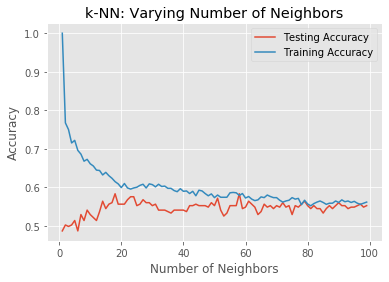

In [62]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 100)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, n_neighbor in enumerate(neighbors):
    
    # Setup a k-NN Classifier with n_neighbor
    knn = KNeighborsClassifier(n_neighbors=n_neighbor)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()


### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm C. Decision Tree                 

In [71]:
# Decision tree algorithm

# Instantiate dt_entropy, set 'entropy' as the information criterion
dt_entropy = DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=1)


# Fit dt_entropy to the training set
dt_entropy.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_entropy.predict(X_test)

# Evaluate accuracy_entropy
accuracy_entropy = accuracy_score(y_test, y_pred)


# Print accuracy_entropy
print('[Decision Tree -- entropy] accuracy_score: {:.3f}.'.format(accuracy_entropy))



# Instantiate dt_gini, set 'gini' as the information criterion
dt_gini = DecisionTreeClassifier(max_depth=8, criterion='gini', random_state=1)


# Fit dt_entropy to the training set
dt_gini.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_gini.predict(X_test)

# Evaluate accuracy_entropy
accuracy_gini = accuracy_score(y_test, y_pred)

# Append to the accuracy list
acc=accuracy_gini
accuracy_lst.append(acc)

# Print accuracy_gini
print('[Decision Tree -- gini] accuracy_score: {:.3f}.'.format(accuracy_gini))

[Decision Tree -- entropy] accuracy_score: 0.714.
[Decision Tree -- gini] accuracy_score: 0.715.


### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm D. Random Forest   
   ##### n_estimators=500                

In [72]:
# Random Forest algorithm

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=500, random_state=78, verbose=3, max_depth = 10)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)


# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)


# Model Accuracy, how often is the classifier correct?
print("[Randon forest algorithm] accuracy_score: {:.3f}.".format(acc))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 500


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 500


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500

building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  4.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[Randon forest algorithm] accuracy_score: 0.707.


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    6.6s finished


In [67]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 1", "Actual 2", "Actual 3", "Actual 4"], 
    columns=["Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4"])
# Calculating the accuracy score.
acc_score = accuracy_score(y_test, y_pred)
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score: {acc_score}")
print("Classification Report")
print(classification_report(y_test, y_pred))

Confusion Matrix


,Predicted 1,Predicted 2,Predicted 3,Predicted 4
Actual 1,0,1128,0,0
Actual 2,0,112226,0,0
Actual 3,0,0,44004,0
Actual 4,0,29,1597,4


Accuracy Score: 0.9826779379575817
Classification Report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1128
           2       0.99      1.00      0.99    112226
           3       0.96      1.00      0.98     44004
           4       1.00      0.00      0.00      1630

    accuracy                           0.98    158988
   macro avg       0.74      0.50      0.50    158988
weighted avg       0.98      0.98      0.97    158988



D:\AnacondaJupyter\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm D. Random Forest   
   ##### Visualize important features      

No handles with labels found to put in legend.


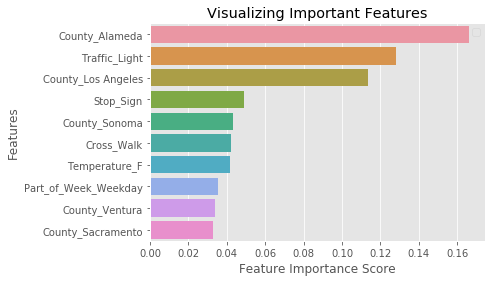

In [75]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

# Creating a bar plot, displaying only the top k features
k=10
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:k])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [76]:
# List top k important features
k=20
feature_imp.sort_values(ascending=False)[:k]

County_Alameda          0.166145
Traffic_Light           0.128153
County_Los Angeles      0.113666
Stop_Sign               0.049177
County_Sonoma           0.042976
Cross_Walk              0.042225
Temperature_F           0.041812
Part_of_Week_Weekday    0.035415
County_Ventura          0.033936
County_Sacramento       0.032763
Part_of_Week_Weekend    0.032420
County_Solano           0.029736
County_Fresno           0.025920
County_San Diego        0.025859
Month_July              0.020964
County_Monterey         0.018946
County_Kern             0.014477
County_Santa Barbara    0.011895
County_Stanislaus       0.010874
County_Santa Cruz       0.009358
dtype: float64

### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm D. Random Forest   
   ##### Select the top important features, set the threshold      

In [77]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.03
sfm = SelectFromModel(clf, threshold=0.03)

# Train the selector
sfm.fit(X_train, y_train)

feat_labels=X.columns

# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 500


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 500


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500

building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  4.4min finished


In [78]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=500, random_state=78, verbose=3, max_depth = 10)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 500


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 500


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500

building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.7min finished


RandomForestClassifier(max_depth=10, n_estimators=500, random_state=78,
                       verbose=3)

In [79]:
# Apply The Full Featured Classifier To The Test Data
y_pred = clf.predict(X_test)

# View The Accuracy Of Our Full Feature Model
print('[Randon forest algorithm -- Full feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_pred)))

# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature Model
print('[Randon forest algorithm -- Limited feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_important_pred)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[Randon forest algorithm -- Full feature] accuracy_score: 0.707.
[Randon forest algorithm -- Limited feature] accuracy_score: 0.712.


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    6.8s finished


### Step 9. Predict the accident severity with various supervised machine learning algorithms

#### Plot the accuracy score versus algorithm

In [80]:
# Make a plot of the accuracy scores for different algorithms

# Generate a list of ticks for y-axis
y_ticks=np.arange(len(algo_lst))

# Combine the list of algorithms and list of accuracy scores into a dataframe, sort the value based on accuracy score
df_acc=pd.DataFrame(list(zip(algo_lst, accuracy_lst)), columns=['Algorithm','Accuracy_Score']).sort_values(by=['Accuracy_Score'],ascending = True)

# Export to a file
df_acc.to_csv('./Accuracy_scores_algorithms_{}.csv'.format(state),index=False)

# Make a plot
ax=df_acc.plot.barh('Algorithm', 'Accuracy_Score', align='center',legend=False,color='0.5')

# Add the data label on to the plot
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+0.02, i.get_y()+0.2, str(round(i.get_width(),2)), fontsize=10)

# Set the limit, lables, ticks and title
plt.xlim(0,1.1)
plt.xlabel('Accuracy Score')
plt.yticks(y_ticks, df_acc['Algorithm'], rotation=0)
plt.title('[{}-{}] Which algorithm is better?')

plt.show()

NameError: name 'state' is not defined

In [81]:
print('Accuracy of logistic regression on training: ', lr.score(X_train_scaled, y_train))
print('Accuracy of logistic regression on testing: ', lr.score(X_test, y_test))

print('Accuracy of random forest on training: ', clf.score(X_train_scaled, y_train))
print('Accuracy of random forest on testing: ', clf.score(X_test, y_test))

print('Accuracy of decision tree on training: ', dt_gini.score(X_train_scaled, y_train))
print('Accuracy of decision tree on testing: ', dt_gini.score(X_test, y_test))

Accuracy of logistic regression on training:  0.49400187750904556
Accuracy of logistic regression on testing:  0.7121417968651722


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   25.6s finished


Accuracy of random forest on training:  0.7058773580900355


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    6.8s finished


Accuracy of random forest on testing:  0.7067766120713513
Accuracy of decision tree on training:  0.7043505060940422
Accuracy of decision tree on testing:  0.7150225174226986


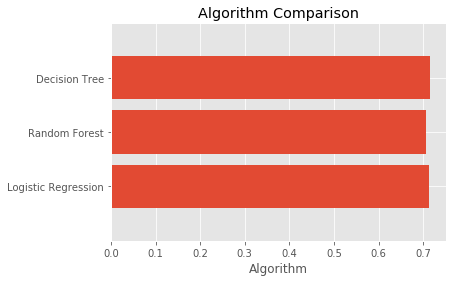

In [86]:
df_graph = pd.read_csv('Accuracy_scores_algorithms_.csv')

ax = plt.barh(y=df_graph['Algorithm'],
        width=df_graph['Accuracy_Score'])

# Set the limit, lables, ticks and title
plt.ylim(-1,3)
plt.xlabel('Algorithm')
plt.title('Algorithm Comparison')

plt.show()

In [84]:
pickle.dump(dt_gini, open('decision_tree_v2.pkl','wb'))